In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-09-13 11:17:32,948: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-09-13 11:17:32,959: INFO: common: yaml file: params.yaml loaded successfully]
[2024-09-13 11:17:32,966: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-09-13 11:17:32,968: INFO: common: created directory at: artifacts]
[2024-09-13 11:17:32,970: INFO: common: created directory at: artifacts/data_ingestion]
[2024-09-13 11:17:37,161: INFO: 3529146271: artifacts/data_ingestion/data.zip downloaded! with following info: 
Connection: close
Content-Length: 1714
Cache-Control: max-age=300
Content-Security-Policy: default-src 'none'; style-src 'unsafe-inline'; sandbox
Content-Type: application/zip
ETag: "84605d55383d7cd948c2e83c2e409eaa2f3d4ee060ce600306078348a64963fd"
Strict-Transport-Security: max-age=31536000
X-Content-Type-Options: nosniff
X-Frame-Options: deny
X-XSS-Protection: 1; mode=block
X-GitHub-Request-Id: A650:3629B2:2EAFB62:30BF951:66E3EE0D
Accept-Ranges: bytes
Date: Fri,

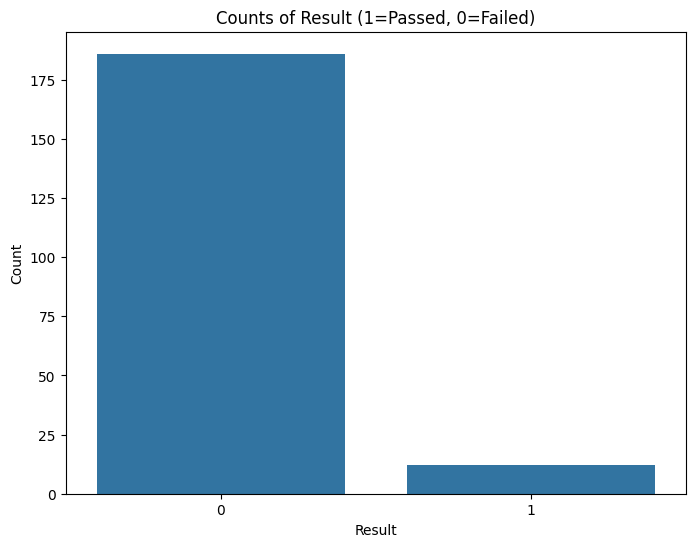

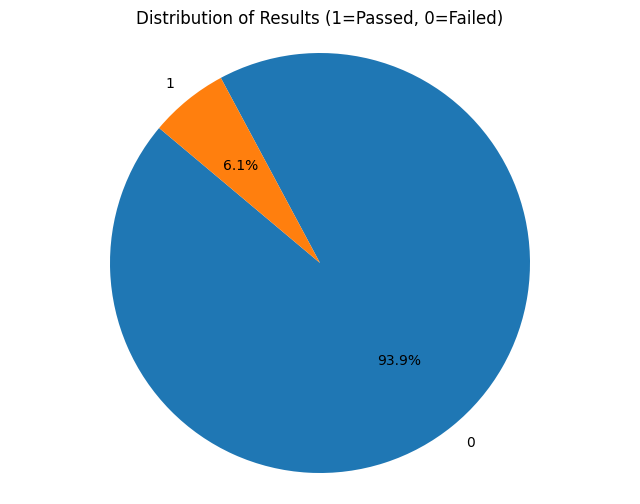

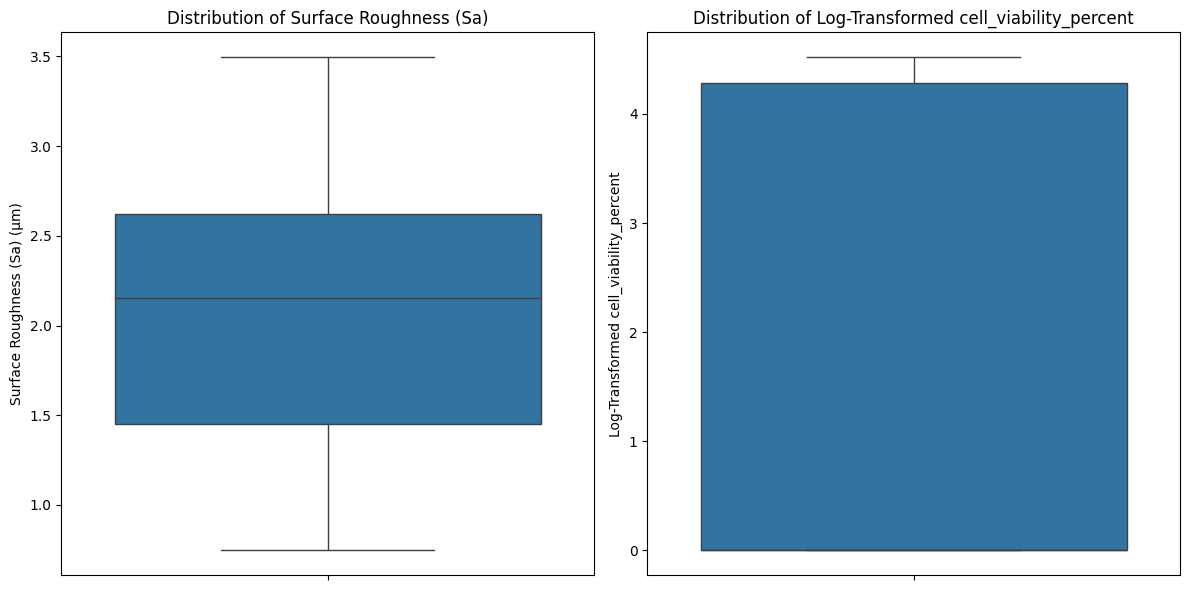

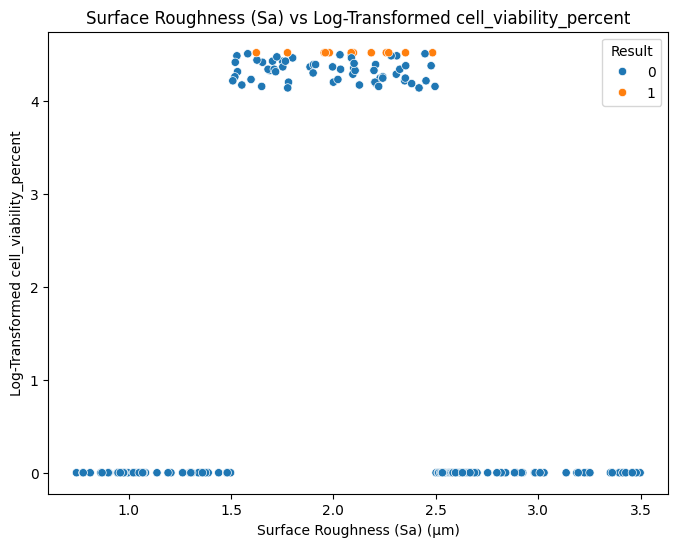

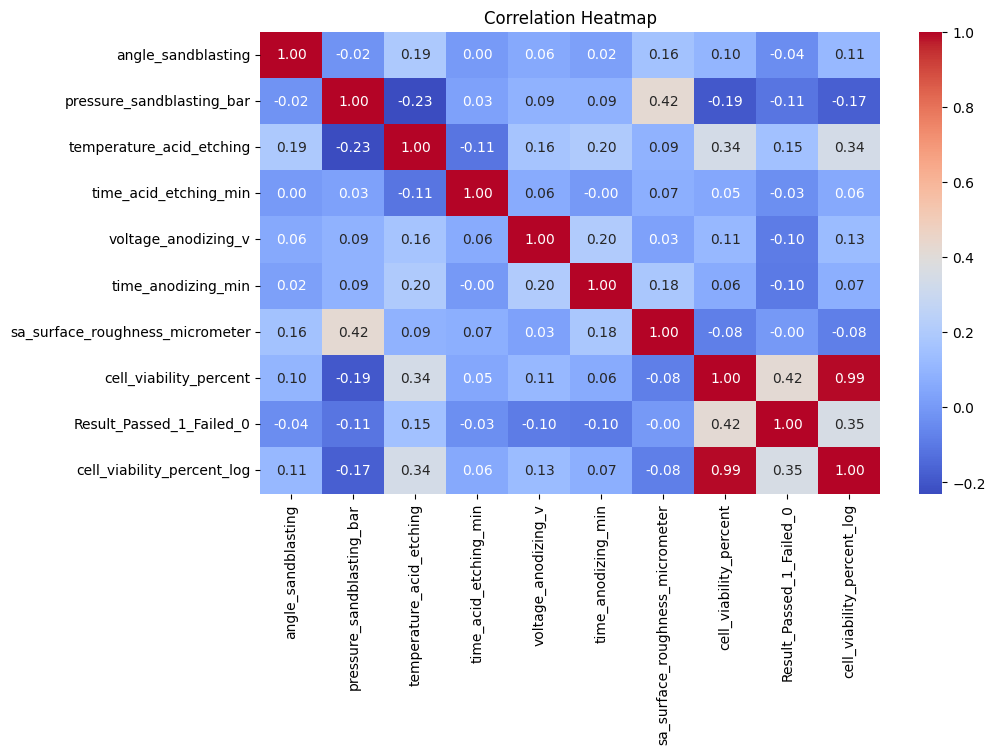

In [5]:
# Import necessary libraries
from dataclasses import dataclass
from pathlib import Path
from Dental_Implant_Sandblasting.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH
from Dental_Implant_Sandblasting.utils.common import read_yaml, create_directories, get_size
import urllib.request as request
from Dental_Implant_Sandblasting import logger
import zipfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, normaltest
from feature_engine.outliers import Winsorizer

# Define data class for configuration
@dataclass(frozen=True)
class DataIngestionConfig:
    root_dir: Path
    source_URL: str
    local_data_file: Path
    unzip_dir: Path
    columns_to_convert: list
    sa_lower_bound: float
    sa_upper_bound: float
    cell_viability_threshold: int
    outlier_capping_method: str
    outlier_tail: str
    outlier_fold: float
    log_transform_variable: str

# Define Configuration Manager
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion
        params = self.params.data_ingestion

        create_directories([config.root_dir])

        data_ingestion_config = DataIngestionConfig(
            root_dir=config.root_dir,
            source_URL=config.source_URL,
            local_data_file=config.local_data_file,
            unzip_dir=config.unzip_dir,
            columns_to_convert=config["columns_to_convert"],        # Access directly from config.yaml
            sa_lower_bound=params["sa_lower_bound"],
            sa_upper_bound=params["sa_upper_bound"],
            cell_viability_threshold=params["cell_viability_threshold"],
            outlier_capping_method=params["outlier_capping_method"],
            outlier_tail=params["outlier_tail"],
            outlier_fold=params["outlier_fold"],
            log_transform_variable=params["log_transform_variable"]
        )

        return data_ingestion_config

# Define Data Ingestion Class
class DataIngestion:
    def __init__(self, config: DataIngestionConfig):
        self.config = config

    def download_file(self):
        if not os.path.exists(self.config.local_data_file):
            filename, headers = request.urlretrieve(
                url=self.config.source_URL,
                filename=self.config.local_data_file
            )
            logger.info(f"{filename} downloaded! with following info: \n{headers}")
        else:
            logger.info(f"File already exists of size: {get_size(Path(self.config.local_data_file))}")

    def extract_zip_file(self):
        unzip_path = self.config.unzip_dir
        os.makedirs(unzip_path, exist_ok=True)
        with zipfile.ZipFile(self.config.local_data_file, 'r') as zip_ref:
            zip_ref.extractall(unzip_path)

    def load_and_explore_data(self):
        # Ensure unzip_dir is a Path object
        unzip_dir = Path(self.config.unzip_dir)

        # Load the dataset
        data_file_path = unzip_dir / "Sandblasting-Condition.csv"
        data = pd.read_csv(data_file_path)

        # Display first few rows of the dataset
        logger.info(f"First few rows of the dataset:\n{data.head()}")

        # Data shape
        logger.info(f"Data shape: {data.shape}")

        # Data types and basic info
        logger.info("Data info:")
        data.info()

        # Summary statistics
        logger.info(f"Summary statistics:\n{data.describe(include='all')}")

        # Check for missing values
        logger.info(f"Missing values by column:\n{data.isnull().sum()}")

        # Handle non-numeric values
        data[self.config.columns_to_convert] = data[self.config.columns_to_convert].apply(pd.to_numeric, errors='coerce')

        # Drop rows with NaN values in these columns
        data = data.dropna(subset=self.config.columns_to_convert)
        logger.info("Data types after cleaning:")
        logger.info(f"{data.dtypes}")

        # Filter data according to the given validation ranges
        valid_data = data[(data['sa_surface_roughness_micrometer'] > self.config.sa_lower_bound) &
                          (data['sa_surface_roughness_micrometer'] < self.config.sa_upper_bound)]

        # Set "Cell Viability (%)" to 0 where Sa is outside the valid range
        data.loc[~data.index.isin(valid_data.index), 'cell_viability_percent'] = 0

        # Set Result (1=Passed, 0=Failed) based on Cell Viability threshold
        data['Result_Passed_1_Failed_0'] = np.where(data['cell_viability_percent'] > self.config.cell_viability_threshold, 1, 0)

        # Outlier handling using Winsorizing
        winsorizer = Winsorizer(capping_method=self.config.outlier_capping_method,
                                tail=self.config.outlier_tail,
                                fold=self.config.outlier_fold,
                                variables=['cell_viability_percent'])
        data['cell_viability_percent'] = winsorizer.fit_transform(data[['cell_viability_percent']])

        # Confirm Winsorizing effect
        logger.info(f"Data after Winsorizing 'cell_viability_percent':\n{data['cell_viability_percent'].describe()}")

        # Apply Log Transformation to the specified variable
        log_variable = self.config.log_transform_variable
        data[f'{log_variable}_log'] = np.log1p(data[log_variable])

        # Check Normality and Skewness after Log Transformation
        skewness_log = skew(data[f'{log_variable}_log'])
        logger.info(f"Skewness of Log-Transformed {log_variable}: {skewness_log:.2f}")

        stat, p = normaltest(data[f'{log_variable}_log'])
        logger.info(f"Normality test p-value for Log-Transformed {log_variable}: {p:.3f}")

        # Exploratory Data Analysis (EDA)

        # 1. Bar Chart: Counts of Result
        plt.figure(figsize=(8, 6))
        sns.countplot(x='Result_Passed_1_Failed_0', data=data)
        plt.title("Counts of Result (1=Passed, 0=Failed)")
        plt.xlabel("Result")
        plt.ylabel("Count")
        plt.show()

        # 2. Pie Chart: Distribution of Results
        result_counts = data['Result_Passed_1_Failed_0'].value_counts()
        plt.figure(figsize=(8, 6))
        plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title("Distribution of Results (1=Passed, 0=Failed)")
        plt.axis('equal')
        plt.show()

        # 3. Box Plot: Distribution of Surface Roughness (Sa) and Cell Viability (%)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.boxplot(y='sa_surface_roughness_micrometer', data=data)
        plt.title("Distribution of Surface Roughness (Sa)")
        plt.ylabel("Surface Roughness (Sa) (µm)")

        plt.subplot(1, 2, 2)
        sns.boxplot(y=f'{log_variable}_log', data=data)
        plt.title(f"Distribution of Log-Transformed {log_variable}")
        plt.ylabel(f"Log-Transformed {log_variable}")

        plt.tight_layout()
        plt.show()

        # 4. Scatter Plot: Surface Roughness (Sa) vs Log-Transformed Cell Viability
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='sa_surface_roughness_micrometer', 
                        y=f'{log_variable}_log', hue='Result_Passed_1_Failed_0', data=data)
        plt.title(f"Surface Roughness (Sa) vs Log-Transformed {log_variable}")
        plt.xlabel("Surface Roughness (Sa) (µm)")
        plt.ylabel(f"Log-Transformed {log_variable}")
        plt.legend(title='Result')
        plt.show()

        # 5. Correlation Heatmap: Focus on Sa and Cell Viability
        plt.figure(figsize=(10, 6))
        sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

# Update the Pipeline
try:
    config = ConfigurationManager()
    data_ingestion_config = config.get_data_ingestion_config()
    data_ingestion = DataIngestion(config=data_ingestion_config)
    data_ingestion.download_file()
    data_ingestion.extract_zip_file()
    data_ingestion.load_and_explore_data()
except Exception as e:
    logger.exception(e)
    raise e
